In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from collections import Counter

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import spacy
spc_nlp = spacy.load('en')

In [4]:
root = 'data/ICNALE/Unmerged_classified'
#root = 'data/pilot3'

In [9]:
df_0 = pwk.load_data_multi(root)
# df_0.head(1)

# cond = (df_0['label']=='HKG')|(df_0['label']=='TWN')
# df_0 = df_0.drop(df_0[cond].index, axis=0)
# df_0 = df_0.reset_index(drop=True)

# from numpy.random import choice
# cond = (df_0['label']=='CHN')
# idx_remove = list(choice(df_0[cond].index, 400, replace=False))
# cond = (df_0['label']=='JPN')
# idx_remove += list(choice(df_0[cond].index, 400, replace=False))
# cond = (df_0['label']=='KOR')
# idx_remove += list(choice(df_0[cond].index, 200, replace=False))
# cond = (df_0['label']=='THA')
# idx_remove += list(choice(df_0[cond].index, 400, replace=False))

# df_0 = df_0.drop(df_0.index[idx_remove])

5600


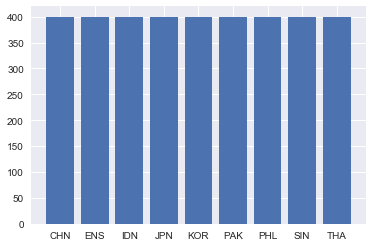

In [10]:
countries = list(df_0.groupby('label').size().index)
sample_count = df_0.groupby('label').size().values
fig, ax = plt.subplots()
ax.bar(range(len(countries)), sample_count)
plt.xticks(range(len(countries)), countries)
fig.show()

**The corpus has 9 perfectly balanced classes**

In [11]:
countries

['CHN', 'ENS', 'IDN', 'JPN', 'KOR', 'PAK', 'PHL', 'SIN', 'THA']

# 1.Ad-hoc Feature Extraction

## Unique words after lemmatization

**I used lemmatization because unlike stemming, lemma considers linguistic meaning of a word, although it uses more resources and is slower**

In [12]:
df_0['unique_lemma'] = df_0['essay_content'].apply(lambda x: len(set([token.lemma_ for token in spc_nlp(x.decode('utf-8')) if token.is_punct==False])))

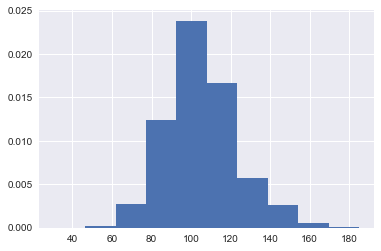

In [13]:
plt.hist(df_0['unique_lemma'], bins = 10, normed=1)
plt.xlim = (0, 200)
plt.ylim = (0, 0.05)
plt.title('Vocabulary Distribution of All Essays')
plt.show()

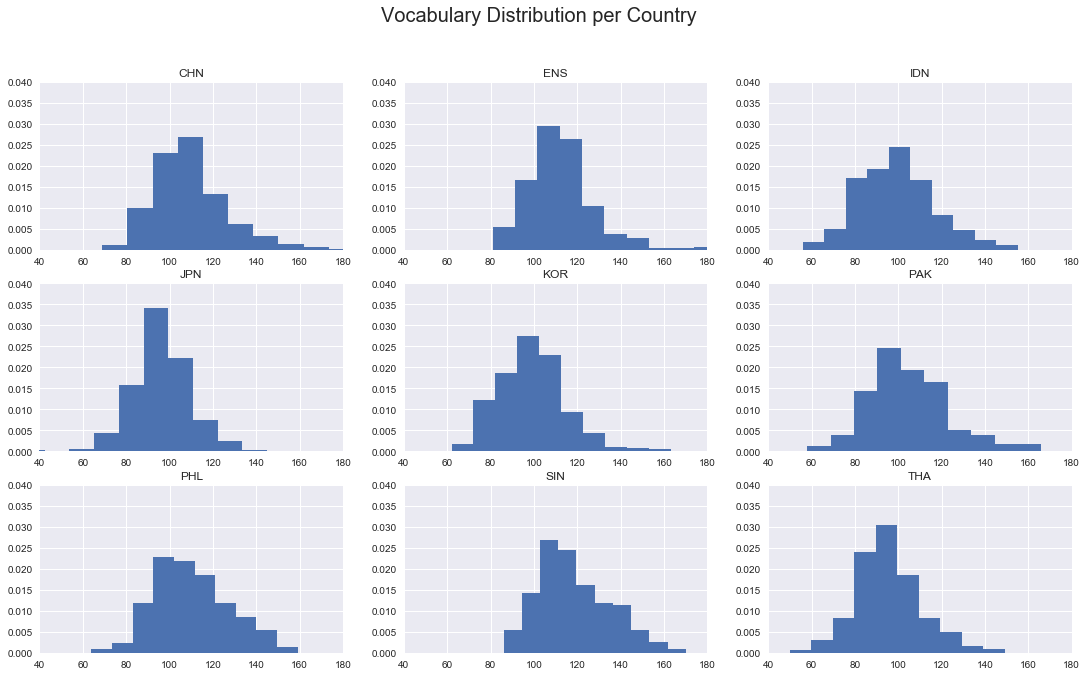

In [30]:
pwk.plot_pattern_country(df_0, 'unique_lemma', 40, 180, 0, 0.04, \
                     'Vocabulary Distribution per Country')

## Average Sentence Length

In [14]:
df_0['avg_stc_length'] = df_0['essay_content'].apply(lambda x: np.mean([len(s) for s in spc_nlp(x.decode('utf-8')).sents]))

In [15]:
np.percentile(df_0['avg_stc_length'], 95)

31.627083333333321

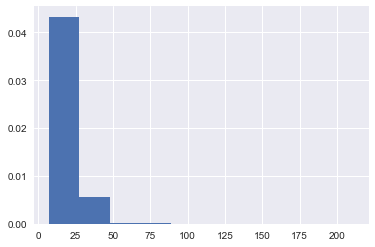

In [16]:
plt.hist(df_0['avg_stc_length'], bins = 10, normed=1)
plt.xlim = (0, 200)
plt.ylim = (0, 0.05)
plt.show()

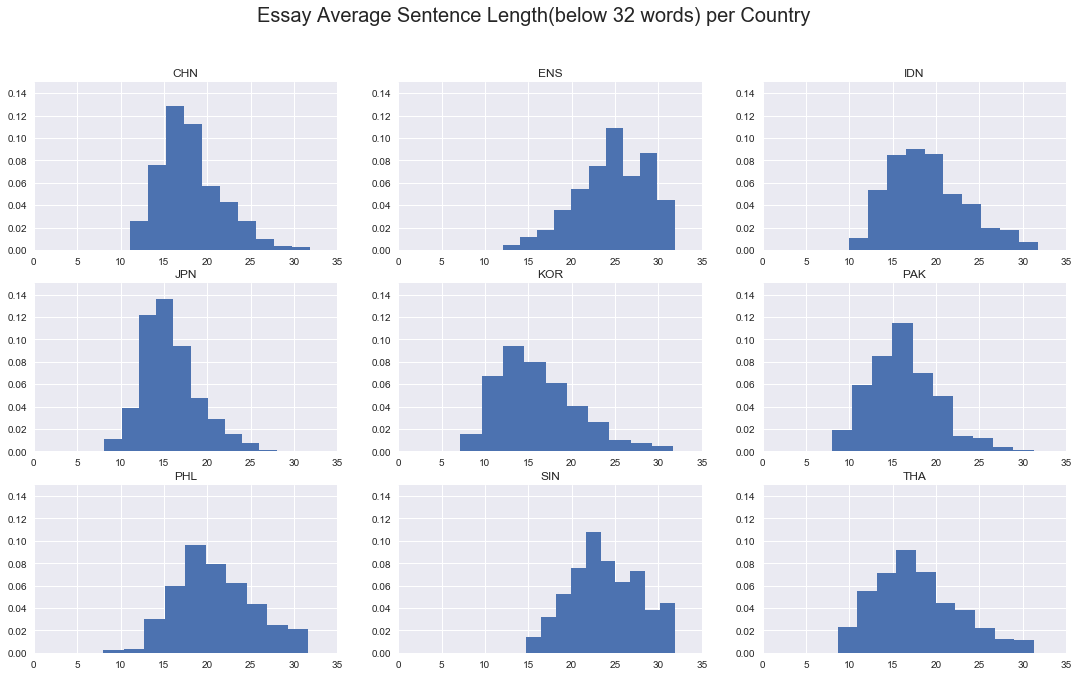

In [31]:
pwk.plot_pattern_country(df_0[(df_0['avg_stc_length']<32)], 'avg_stc_length', \
                         0, 35, 0, 0.15, \
                     'Essay Average Sentence Length(below 32 words) per Country')

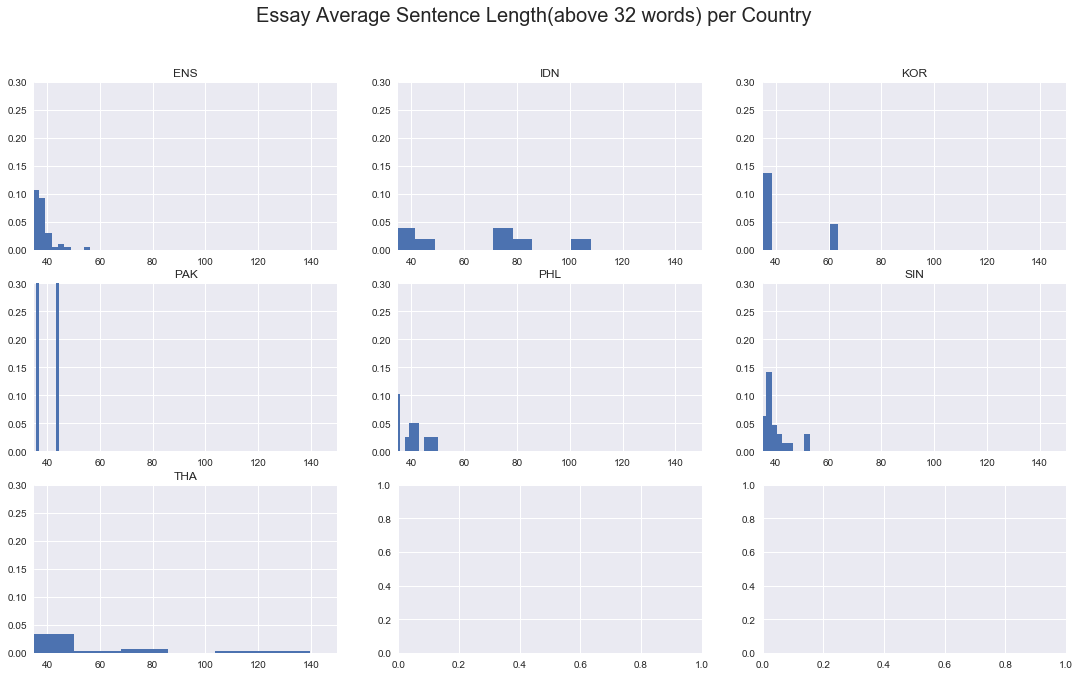

In [33]:
pwk.plot_pattern_country(df_0[(df_0['avg_stc_length']>32)], 'avg_stc_length', \
                         35, 150, 0, 0.3, \
                     'Essay Average Sentence Length(above 32 words) per Country')

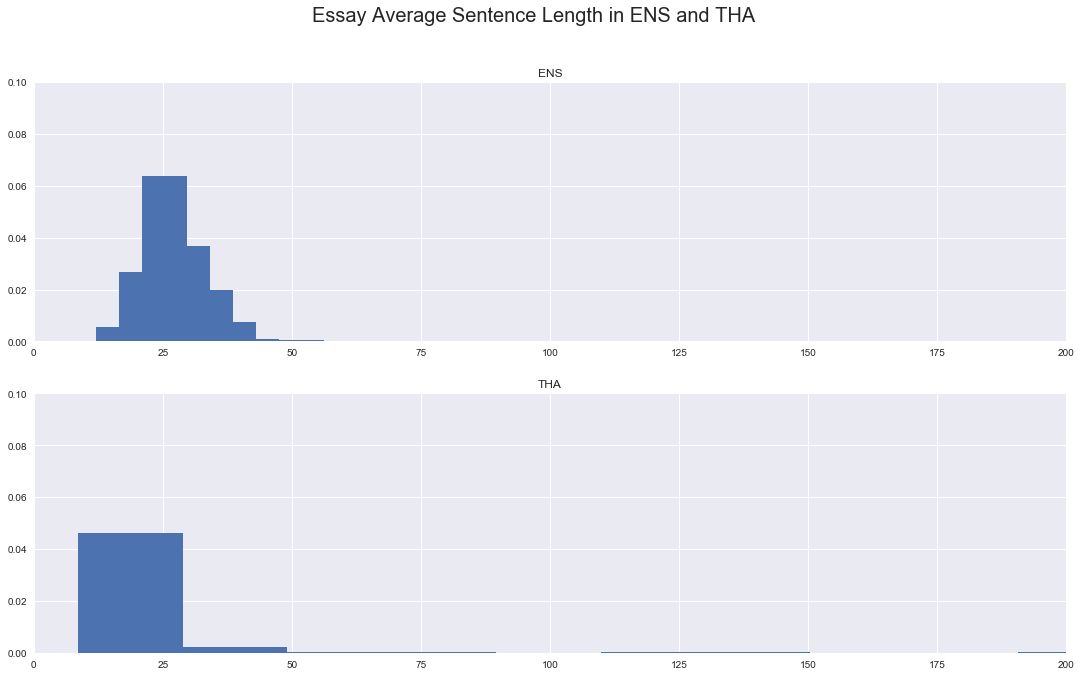

In [37]:
countries = ['ENS', 'THA']
fig, axs = plt.subplots(2)
for c, ax in zip(countries, axs.flatten()):
    data = df_0[(df_0['label']==c)]['avg_stc_length']
    ax.hist(data, bins=10, normed=1)
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 0.1)
    ax.set_title(c)
fig.suptitle('Essay Average Sentence Length in ENS and THA', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

**Compare to native speakers, learners from Thailand tend to write more much longer sentences. This may be explained by the fact that in Thai(the language) script, full-stop doesn't exist. Therefore, the learners brought this habit to their L2 (English) writing**

## Total Sentence Count

In [17]:
#start = time()
df_0['total_stc'] = df_0['essay_content'].apply(lambda x: len([s for s in spc_nlp(x.decode('utf-8')).sents]))
#end = time()
#duration = end - start
#print duration

In [18]:
np.percentile(df_0['total_stc'], 5)

8.0

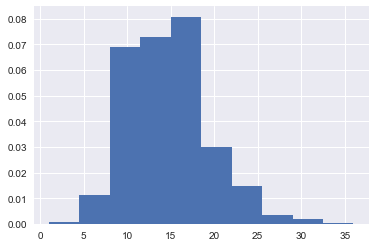

In [19]:
plt.hist(df_0['total_stc'], bins = 10, normed=1)
plt.xlim = (0, 40)
plt.ylim = (0, 0.1)
plt.show()

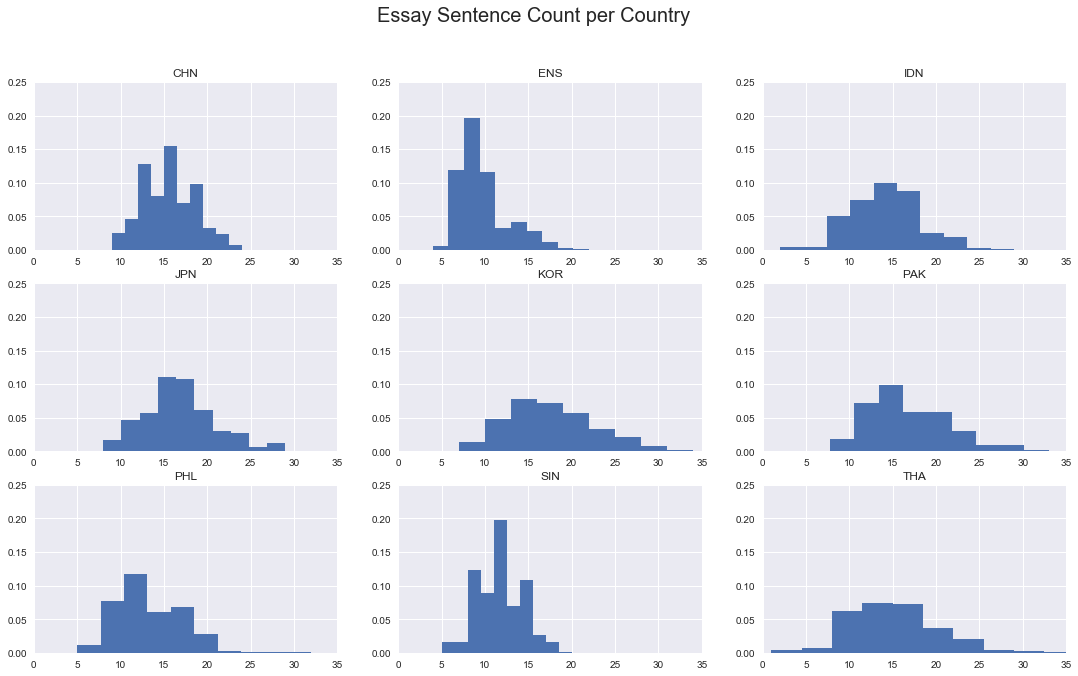

In [38]:
pwk.plot_pattern_country(df_0, 'total_stc', 0, 35, 0, 0.25, \
                     'Essay Sentence Count per Country')

In [20]:
np.median(df_0['total_stc'])

14.0

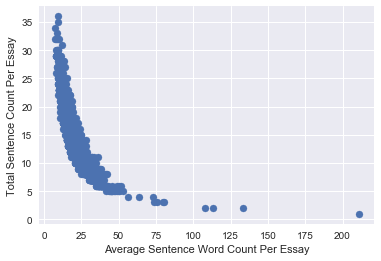

In [21]:
fig,ax = plt.subplots()
ax.scatter(df_0['avg_stc_length'], df_0['total_stc'])
ax.set_xlabel('Average Sentence Word Count Per Essay')
ax.set_ylabel('Total Sentence Count Per Essay')
plt.show()

**avg_stc_length and total_stc grow inversely**

# 2. POS Tagging and Dependent Tree Parsing Features

## POS Tagging

In [22]:
df_0['DT_pos'] = df_0['essay_content'].apply(lambda x: [' '.join([token.pos_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])


In [44]:
df_0['DT_pos'][0]

[u'NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART VERB ADV PUNCT NOUN NOUN PUNCT',
 u'ADV PUNCT DET ADJ NOUN ADP NOUN NOUN VERB VERB DET ADJ PUNCT NOUN NOUN PUNCT',
 u'DET ADP PRON VERB DET NOUN PUNCT NOUN NOUN VERB VERB PRON PART VERB ADP DET NOUN ADV CCONJ VERB PRON ADJ NOUN PUNCT',
 u'VERB DET NOUN ADP NOUN ADP NOUN PUNCT ADV PROPN VERB DET NOUN NOUN PUNCT PRON VERB ADP NOUN ADP DET NOUN CCONJ VERB PART VERB DET NOUN NOUN DET NOUN PUNCT',
 u'ADV VERB ADP ADJ NOUN PUNCT PRON ADV VERB DET ADJ NOUN ADP VERB ADP NOUN PUNCT',
 u'ADP DET ADJ NOUN PART NOUN PUNCT PRON VERB ADP PRON VERB VERB NOUN PRON VERB ADJ NOUN VERB ADV VERB PUNCT',
 u'PRON VERB DET NOUN ADJ PRON VERB ADP DET NOUN ADP DET NOUN ADP ADJ ADJ PUNCT NOUN PART VERB ADJ NOUN NOUN DET NOUN VERB PUNCT',
 u'ADV PUNCT PRON VERB ADJ ADP NOUN NOUN PART VERB DET ADJ PUNCT NOUN NOUN PUNCT',
 u'ADV PUNCT ADJ NOUN ADV VERB ADV VERB PRON PART VERB ADJ PUNCT NOUN NOUN PUNCT',
 u'PRON VERB ADJ ADP ADJ NOUN CCONJ NOUN PUNCT',
 u'ADP ADJ NO

### Repetition of Adjective and Adverb Based on DT_pos

In [23]:
df_0['POS_adjv_body'] = df_0['essay_content'].apply(lambda x: [token.text.lower() for token in spc_nlp(x.decode('utf-8')) if (token.dep_=='amod')|(token.dep_=='advmod')])    


In [24]:
df_0['POS_adjv_repeat_rate'] = df_0['POS_adjv_body'].apply(lambda x: len([k for k, v in dict(Counter(x)).iteritems() if v>1])*1./len(x))


In [45]:
df_0['POS_adjv_repeat_rate'][0]

0.058823529411764705

In [25]:
df_0['POS_adjv_repeat_cnt'] = df_0['POS_adjv_body'].apply(lambda x: sum([v for k, v in dict(Counter(x)).iteritems() if v>1]))


In [46]:
df_0['POS_adjv_repeat_cnt'][0]

2

## Dependent Tree Parsing

In [39]:
df_0['DT_archs'] = df_0['essay_content'].apply(lambda x: [' '.join([token.dep_ for token in spc_nlp(s.text)]) for s in spc_nlp(x.decode('utf-8')).sents])

In [47]:
df_0['DT_archs'][0]

[u'nsubj ROOT mark nsubj ccomp acomp mark compound nsubj aux advcl amod punct compound dobj punct',
 u'advmod punct det amod nsubj prep compound pobj aux ROOT det compound punct compound dobj punct',
 u'nsubj prep pobj ROOT mark compound punct compound nsubj aux ccomp nsubj aux ccomp prep det pobj advmod cc conj dative amod dobj punct',
 u'advcl det dobj prep pobj prep pobj punct advmod nsubj advcl det compound attr punct nsubj ROOT prep pobj prep det pobj cc conj aux xcomp det compound attr det npadvmod punct',
 u'advmod prep prep poss pobj punct nsubj advmod ROOT det amod dobj prep pcomp prep pobj punct',
 u'prep det amod poss case pobj punct nsubj ROOT mark nsubj aux ccomp dobj nsubj relcl poss nsubj aux neg ccomp punct',
 u'nsubj ROOT det dobj dobj nsubj relcl prep det pobj prep det pobj prep poss compound punct pobj aux advcl amod dobj dobj det nsubj relcl punct',
 u'advmod punct nsubj ROOT acomp mark compound nsubj aux advcl det compound punct compound dobj punct',
 u'advmod punc

In [40]:
df_0['DT_max_dp_cnts'] = df_0['essay_content'].apply(lambda x: [max([len([c for c in token.children]) \
                                                                  for token in spc_nlp(s.text)]) \
                                                                      for s in spc_nlp(x.decode('utf-8')).sents])

In [48]:
df_0['DT_max_dp_cnts'][0]

[4, 6, 6, 8, 8, 5, 4, 6, 8, 4, 5, 7, 6]

In [41]:
df_0['DT_ROOT_idx'] = df_0['DT_archs'].apply(lambda x: [[i for i,e in enumerate(s.split(' ')) if e=='ROOT'][0] for s in x])

In [49]:
df_0['DT_ROOT_idx'][0]

[1, 9, 3, 16, 8, 8, 1, 3, 7, 1, 11, 2, 4]

In [42]:
df_0['DT_pass_cnt'] = df_0['DT_archs'].apply(lambda x: [len([dep for dep in s.split(' ') if dep[-4:]=='pass']) for s in x])

In [50]:
df_0['DT_pass_cnt'][0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
df_0['DT_mark_cnt'] = df_0['DT_archs'].apply(lambda x: [len([dep for dep in s.split(' ') if dep=='mark']) for s in x])

In [51]:
df_0['DT_mark_cnt'][0]

[2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]

## BOW based on DT_pos and DT_archs

In [52]:
df_0['DT_pos_join'] = df_0['DT_pos'].apply(lambda x: ' '.join(x))

In [53]:
df_0['DT_archs_join'] = df_0['DT_archs'].apply(lambda x: ' '.join(x))

In [55]:
n = 4
df_0['DT_insent_pos_ngram'] = df_0['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [57]:
df_0['DT_insent_pos_ngram'][0]

u'NOUN_VERB_ADP_PRON VERB_ADP_PRON_VERB ADP_PRON_VERB_ADJ PRON_VERB_ADJ_ADP VERB_ADJ_ADP_NOUN ADJ_ADP_NOUN_NOUN ADP_NOUN_NOUN_PART NOUN_NOUN_PART_VERB NOUN_PART_VERB_ADV PART_VERB_ADV_PUNCT VERB_ADV_PUNCT_NOUN ADV_PUNCT_NOUN_NOUN PUNCT_NOUN_NOUN_PUNCT ADV_PUNCT_DET_ADJ PUNCT_DET_ADJ_NOUN DET_ADJ_NOUN_ADP ADJ_NOUN_ADP_NOUN NOUN_ADP_NOUN_NOUN ADP_NOUN_NOUN_VERB NOUN_NOUN_VERB_VERB NOUN_VERB_VERB_DET VERB_VERB_DET_ADJ VERB_DET_ADJ_PUNCT DET_ADJ_PUNCT_NOUN ADJ_PUNCT_NOUN_NOUN PUNCT_NOUN_NOUN_PUNCT DET_ADP_PRON_VERB ADP_PRON_VERB_DET PRON_VERB_DET_NOUN VERB_DET_NOUN_PUNCT DET_NOUN_PUNCT_NOUN NOUN_PUNCT_NOUN_NOUN PUNCT_NOUN_NOUN_VERB NOUN_NOUN_VERB_VERB NOUN_VERB_VERB_PRON VERB_VERB_PRON_PART VERB_PRON_PART_VERB PRON_PART_VERB_ADP PART_VERB_ADP_DET VERB_ADP_DET_NOUN ADP_DET_NOUN_ADV DET_NOUN_ADV_CCONJ NOUN_ADV_CCONJ_VERB ADV_CCONJ_VERB_PRON CCONJ_VERB_PRON_ADJ VERB_PRON_ADJ_NOUN PRON_ADJ_NOUN_PUNCT VERB_DET_NOUN_ADP DET_NOUN_ADP_NOUN NOUN_ADP_NOUN_ADP ADP_NOUN_ADP_NOUN NOUN_ADP_NOUN_PUNCT AD

In [56]:
n = 3
df_0['DT_insent_arch_ngram'] = df_0['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [58]:
df_0['DT_insent_arch_ngram'][0]

u'nsubj_ROOT_mark ROOT_mark_nsubj mark_nsubj_ccomp nsubj_ccomp_acomp ccomp_acomp_mark acomp_mark_compound mark_compound_nsubj compound_nsubj_aux nsubj_aux_advcl aux_advcl_amod advcl_amod_punct amod_punct_compound punct_compound_dobj compound_dobj_punct advmod_punct_det punct_det_amod det_amod_nsubj amod_nsubj_prep nsubj_prep_compound prep_compound_pobj compound_pobj_aux pobj_aux_ROOT aux_ROOT_det ROOT_det_compound det_compound_punct compound_punct_compound punct_compound_dobj compound_dobj_punct nsubj_prep_pobj prep_pobj_ROOT pobj_ROOT_mark ROOT_mark_compound mark_compound_punct compound_punct_compound punct_compound_nsubj compound_nsubj_aux nsubj_aux_ccomp aux_ccomp_nsubj ccomp_nsubj_aux nsubj_aux_ccomp aux_ccomp_prep ccomp_prep_det prep_det_pobj det_pobj_advmod pobj_advmod_cc advmod_cc_conj cc_conj_dative conj_dative_amod dative_amod_dobj amod_dobj_punct advcl_det_dobj det_dobj_prep dobj_prep_pobj prep_pobj_prep pobj_prep_pobj prep_pobj_punct pobj_punct_advmod punct_advmod_nsubj advm

**Transform text body into tfidf matrix**

In [88]:
X = df_0['DT_pos_join']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1)).fit(X_train)
X_train_dtm = vectorizer.transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

**Based on those numeric-list-base features, several statistics can be calculated on the list for each essay**

In [89]:
df_0['DT_max_dp_cnts_std'] = df_0['DT_max_dp_cnts'].apply(lambda x: np.std(x))
df_0['DT_ROOT_idx_mean'] = df_0['DT_ROOT_idx'].apply(lambda x: np.mean(x))
df_0['DT_pass_cnt_sum'] = df_0['DT_pass_cnt'].apply(lambda x: np.sum(x))
df_0['DT_mark_cnt_sum'] = df_0['DT_mark_cnt'].apply(lambda x: np.sum(x))

**-**

In [93]:
df_0.to_pickle('data/pickles/20180117_part_one.pkl')